<a href="https://colab.research.google.com/github/Vallasc/Image-processing-on-spark/blob/master/image_denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image processing using a Spark cluster

#### Create env file: *RUN ONLY FIRST TIME!*

In [ ]:
!pip install colab-env --upgrade
import colab_env
colab_env.envvar_handler.add_env("GOOGLE_PROJECT_ID", "insert_gc_project_id", overwrite=True)
colab_env.envvar_handler.add_env("BUCKET", "imageProcessingBucket", overwrite=True)

## Setup environment

In [ ]:
# Import global variables from Google Drive
!pip install colab-env --upgrade
import colab_env
!more gdrive/My\ Drive/vars.env

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive
COLAB_ENV = Active
GOOGLE_PROJECT_ID = scala-image-processing
CLUSTER_REGION = insert_cluster-regione-name
CLUSTER_ZONE = insert_cluster-zone-name
BUCKET = scala-image-processing-bucket


In [ ]:
# Google Cloud auth
import os
from google.colab import auth
auth.authenticate_user()

project_id = os.getenv("GOOGLE_PROJECT_ID")
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
# Create project bucket
bucket_id = os.getenv("BUCKET")
!gsutil mb -l us-central1 -b on -p {project_id} gs://{bucket_id}

Creating gs://scala-image-processing-bucket/...


In [ ]:
# Sync colab bucket directory with project bucket
GCSFUSE_REPO = ! lsb_release -c -s
!echo "deb http://packages.cloud.google.com/apt gcsfuse-{GCSFUSE_REPO[0]} main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

!apt update
!apt -qq install gcsfuse
!mkdir -p bucket
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_id} bucket

deb http://packages.cloud.google.com/apt gcsfuse-bionic main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  24161      0 --:--:-- --:--:-- --:--:-- 23933
OK
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5,391 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/

In [ ]:
# Copy jar executable and data images on the bucket
!rm -rf code
!git clone https://github.com/Vallasc/gibbs-image-denoiser code
!cp -R ./code/jar ./bucket
!cp -R ./code/data ./bucket

Cloning into 'code'...
remote: Enumerating objects: 637, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 637 (delta 46), reused 122 (delta 34), pack-reused 493
Receiving objects: 100% (637/637), 351.23 MiB | 32.54 MiB/s, done.
Resolving deltas: 100% (237/237), done.


## Simple cluster


In [ ]:
# 2 VM 2 core each
!gcloud dataproc clusters create image-processing-cluster \
    --enable-component-gateway \
    --bucket {bucket_id} \
    --region us-central1 \
    --zone us-central1-a \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd \
    --master-boot-disk-size 64 \
    --num-workers 2 \
    --worker-machine-type n1-standard-2 \
    --worker-boot-disk-size 64 \
    --image-version 2.0-debian10 \
    --max-idle 3600s \
    --project scala-image-processing

Waiting on operation [projects/scala-image-processing/regions/us-central1/operations/51e82843-a782-3a4e-90a4-745aa6e3fdfb].

Created [https://dataproc.googleapis.com/v1/projects/scala-image-processing/regions/us-central1/clusters/image-processing-cluster] Cluster placed in zone [us-central1-a].


**Test image**

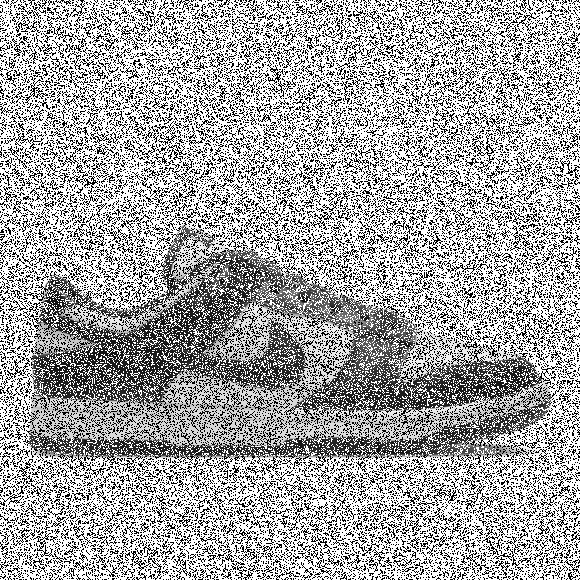

In [ ]:
from IPython.display import Image
Image(filename='./bucket/data/nike_noisy.png') 

In [ ]:
!gcloud dataproc jobs submit spark \
    --region=us-central1 \
    --cluster=image-processing-cluster \
    --properties=driver-memory=4G \
    --class Main \
    --jars gs://{bucket_id}/jar/binary.jar \
    -- --output_file_json gs://{bucket_id}/data/nike_processed.json \
    --output_file_image gs://{bucket_id}/data/nike_processed.png \
    --sub_matrix_size 100 \
    --denoiser_runs 90 \
    --piepeline GibbsEdgeDetection \
    gs://{bucket_id}/data/nike_noisy.png

Job [4282b83519d045449d5ac40231e35abc] submitted.
Waiting for job output...

Input file: gs://scala-image-processing-bucket/data/nike_noisy.png
Output file: gs://scala-image-processing-bucket/data/nike_processed.png
Output json: gs://scala-image-processing-bucket/data/nike_processed.json
Sub matrix size: 100
Paddding: 3

Start
22/07/01 12:13:01 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/07/01 12:13:01 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/07/01 12:13:01 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/07/01 12:13:01 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/07/01 12:13:02 INFO org.sparkproject.jetty.util.log: Logging initialized @6196ms to org.sparkproject.jetty.util.log.Slf4jLog
22/07/01 12:13:02 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_332-b09
22/07/01 12:13:02 INFO o

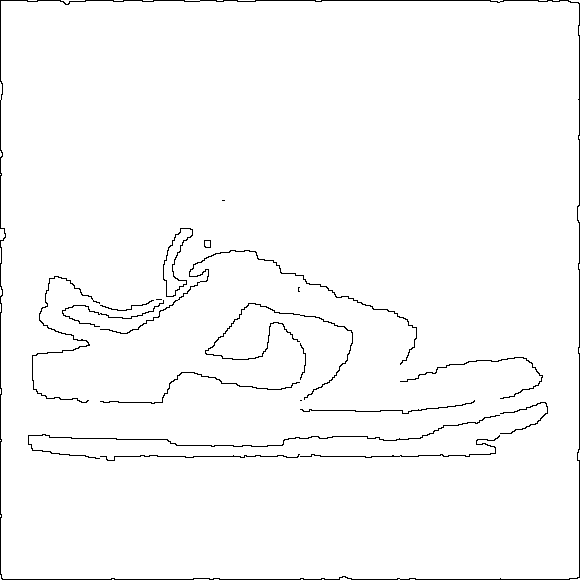

In [ ]:
from IPython.display import Image
Image(filename='./bucket/data/nike_processed.png') 

In [ ]:
import json

with open("./bucket/data/nike_processed.json", "r") as fid: 
      obj = json.load(fid)
print(obj)

{'time': 36691, 'inputPiepeline': 'GibbsEdgeDetection', 'inputPathImage': 'gs://scala-image-processing-bucket/data/nike_noisy.png', 'outputPathImage': 'gs://scala-image-processing-bucket/data/nike_processed.png', 'outputPathJson': 'gs://scala-image-processing-bucket/data/nike_processed.json', 'denoiserRuns': 90, 'padding': 3, 'subHeight': 100, 'subWidth': 100}


## Strong scalability

In [ ]:
import json
import time

# master N1, 4 cores, SSD boot drive
# max 5 VM (N1, 8GB ram) - 4 core each = 20 cores
# 1 run, 1 worker, 4 cores
# 2 run, 2 workers, 8 cores
# 3 run, 3 workers, 12 cores
# 4 run, 4 workers, 16 cores
# 5 run, 5 workers, 20 cores

jobs_times = []
real_times = []
cores = 4
min_vm = 1
max_vm = 5
num_workers = list(range(min_vm, max_vm + 1))
image = "test_4.png" # 8k resolution

for vm in num_workers:
  print(f"Running test vm: " + str(vm))
  # Create cluster
  if vm == 1:
    !gcloud dataproc clusters create image-processing-cluster \
        --enable-component-gateway \
        --single-node \
        --bucket {bucket_id} \
        --region us-central1 \
        --zone us-central1-a \
        --master-machine-type n1-standard-4 \
        --master-boot-disk-type pd-ssd \
        --master-boot-disk-size 32 \
        --image-version 2.0-debian10 \
        --max-idle 3600s \
        --project scala-image-processing
  else:
    !gcloud dataproc clusters create image-processing-cluster \
        --enable-component-gateway \
        --bucket {bucket_id} \
        --region us-central1 \
        --zone us-central1-a \
        --master-machine-type n1-standard-4 \
        --master-boot-disk-type pd-ssd \
        --master-boot-disk-size 32 \
        --num-workers {vm} \
        --worker-machine-type custom-4-8192-ext \
        --worker-boot-disk-size 32 \
        --image-version 2.0-debian10 \
        --max-idle 3600s \
        --project scala-image-processing
  start_real_time = time.time() 
  # Run job
  !gcloud dataproc jobs submit spark \
      --region=us-central1 \
      --cluster=image-processing-cluster \
      --properties=spark.driver.memory=12G \
      --class Main \
      --jars gs://{bucket_id}/jar/binary.jar \
      -- --output_file_json gs://{bucket_id}/data/test_strong_{vm}.json \
      --output_file_image gs://{bucket_id}/data/out_test_strong_{vm}.png \
      --sub_matrix_size 100 \
      --denoiser_runs 150 \
      --piepeline GibbsEdgeDetection \
      gs://{bucket_id}/data/{image}
  # Delete cluster
  !gcloud dataproc clusters delete image-processing-cluster --region=us-central1 --quiet
  # Read execution time
  with open("./bucket/data/test_strong_" + str(vm) + ".json", "r") as fid: 
      time_job = round(json.load(fid)["time"] / 1000)
  real_time = round(time.time() - start_real_time)

  jobs_times.append(time_job)
  real_times.append(real_time)

  print("Job time: " + str(time_job) + "s")
  print("Real execution time: " + str(real_time) + "s")

print("All jobs times: " + str(jobs_times))
print("All real times: " + str(real_times))

Running test vm: 1
Waiting on operation [projects/scala-image-processing/regions/us-central1/operations/157d78fd-075c-3bc9-8c75-44a92318f8fb].
Created [https://dataproc.googleapis.com/v1/projects/scala-image-processing/regions/us-central1/clusters/image-processing-cluster] Cluster placed in zone [us-central1-a].
Job [a46c337186c24fdbb21ebbcac5261b42] submitted.
Waiting for job output...

Input file: gs://scala-image-processing-bucket/data/test_4.png
Output file: gs://scala-image-processing-bucket/data/out_test_strong_1.png
Output json: gs://scala-image-processing-bucket/data/test_strong_1.json
Sub matrix size: 100
Paddding: 3

Start
22/07/02 12:08:38 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/07/02 12:08:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/07/02 12:08:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/07/02 12:08:38 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/07/02 12:08:38 INFO 

Cores: [4, 8, 12, 16, 20]
Times: [18.8, 10.8, 7.12, 6.05, 4.63]


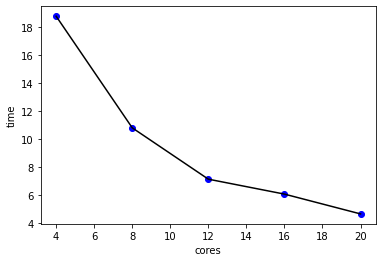

In [ ]:
# Plot results
import matplotlib.pyplot as plt
num_cores = list(map(lambda x : x * cores, num_workers))
times_sec = list(map(lambda x : round(x / 60, 2), jobs_times))
print("Cores: " + str(num_cores))
print("Times: " + str(times_sec))
print()
plt.plot(num_cores, times_sec, 'bo', num_cores, times_sec, 'k')
plt.ylabel('time')
plt.xlabel('cores')
plt.show()

## Weak scalability

In [ ]:
import json
import time

# master N1, 4 cores, SSD boot drive
# max 8 VM (N1, 8GB ram) - 4 core each = 32 vcore

# 1 run, 2 cores, 2x 2k image
# 2 run, 4 cores, 4k image
# 3 run, 8 cores, 2x 4k image
# 4 run, 16 cores, 8k image

img_pixels = [4423680, 9068544, 18137088, 36274176]
jobs_times = []
real_times = []
cores = 4
num_workers = [0, 1, 2, 4]

for vm in num_workers:
  print(f"Running test vm: " + str(vm))
  # Create cluster
  if vm == 0:
    !gcloud dataproc clusters create image-processing-cluster \
        --enable-component-gateway \
        --single-node \
        --bucket {bucket_id} \
        --region us-central1 \
        --zone us-central1-a \
        --master-machine-type custom-2-13312-ext \
        --master-boot-disk-type pd-ssd \
        --master-boot-disk-size 32 \
        --image-version 2.0-debian10 \
        --max-idle 3600s \
        --project scala-image-processing
  elif vm == 1:
    !gcloud dataproc clusters create image-processing-cluster \
        --enable-component-gateway \
        --single-node \
        --bucket {bucket_id} \
        --region us-central1 \
        --zone us-central1-a \
        --master-machine-type n1-standard-4 \
        --master-boot-disk-type pd-ssd \
        --master-boot-disk-size 32 \
        --image-version 2.0-debian10 \
        --max-idle 3600s \
        --project scala-image-processing
  else:
    !gcloud dataproc clusters create image-processing-cluster \
        --enable-component-gateway \
        --bucket {bucket_id} \
        --region us-central1 \
        --zone us-central1-a \
        --master-machine-type n1-standard-4 \
        --master-boot-disk-type pd-ssd \
        --master-boot-disk-size 32 \
        --num-workers {vm} \
        --worker-machine-type custom-4-8192-ext \
        --worker-boot-disk-size 32 \
        --image-version 2.0-debian10 \
        --max-idle 3600s \
        --project scala-image-processing
  start_real_time = time.time() 
  # Run job
  !gcloud dataproc jobs submit spark \
      --region=us-central1 \
      --cluster=image-processing-cluster \
      --properties=spark.driver.memory=8G \
      --class Main \
      --jars gs://{bucket_id}/jar/binary.jar \
      -- --output_file_json gs://{bucket_id}/data/test_weak_{vm}.json \
      --output_file_image gs://{bucket_id}/data/out_test_weak_{vm}.png \
      --sub_matrix_size 100 \
      --denoiser_runs 100 \
      --piepeline GibbsEdgeDetection \
      gs://{bucket_id}/data/test_{vm}.png
  # Delete cluster
  !gcloud dataproc clusters delete image-processing-cluster --region=us-central1 --quiet
  # Read execution time
  with open("./bucket/data/test_weak_" + str(vm) + ".json", "r") as fid:
      time_job = round(json.load(fid)["time"] / 1000)
  real_time = round(time.time() - start_real_time)

  jobs_times.append(time_job)
  real_times.append(real_time)

  print("Job time: " + str(time_job) + "s")
  print("Real execution time: " + str(real_time) + "s")

print("All jobs times: " + str(jobs_times))
print("All real times: " + str(real_times))

Running test vm: 0
Waiting on operation [projects/scala-image-processing/regions/us-central1/operations/17f1f9ba-b94e-36a9-acb7-cdd8b779e020].
Created [https://dataproc.googleapis.com/v1/projects/scala-image-processing/regions/us-central1/clusters/image-processing-cluster] Cluster placed in zone [us-central1-a].
Job [18e3e37801b74f3f9c957b03e3d4f275] submitted.
Waiting for job output...

Input file: gs://scala-image-processing-bucket/data/test_0.png
Output file: gs://scala-image-processing-bucket/data/out_test_weak_0.png
Output json: gs://scala-image-processing-bucket/data/test_weak_0.json
Sub matrix size: 100
Paddding: 3

Start
22/07/02 14:01:04 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/07/02 14:01:04 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/07/02 14:01:04 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/07/02 14:01:04 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/07/02 14:01:04 INFO org.

Cores: [0, 4, 8, 16]
Times: [3.07, 4.75, 4.0, 3.73]



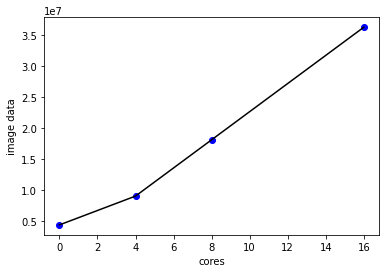

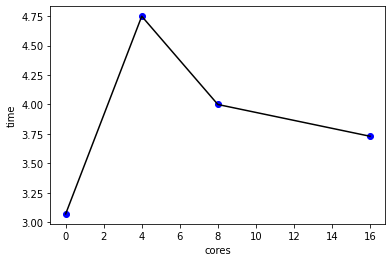

In [ ]:
# Plot results
import matplotlib.pyplot as plt
num_cores = list(map(lambda x : x * cores, num_workers))
times_sec = list(map(lambda x : round(x / 60, 2), jobs_times))
print("Cores: " + str(num_cores))
print("Times: " + str(times_sec))
print()
plt.plot(num_cores, img_pixels, 'bo', num_cores, img_pixels, 'k')
plt.ylabel('image data')
plt.xlabel('cores')
plt.show()
print()
plt.plot(num_cores, times_sec, 'bo', num_cores, times_sec, 'k')
plt.ylabel('time')
plt.xlabel('cores')
plt.show()

## Web interface

In [ ]:
# Cluster needs to be started
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(9090)"))

!pip install bottle
from bottle import route, request, run, static_file, FileUpload
import time
import os

cloud_bucket = "gs://{b_id}/data".format(b_id=bucket_id)
local_bucket = "./bucket/data"

def millis():
    return int(round(time.time() * 1000))

@route('/')
def root():
    return static_file('./code/web/public/index.html', root='.')

@route('/bucket/data/<filename>')
def serve_files(filename):
    try:
        return static_file(filename, root = local_bucket)
    except: 
        print(dir + "/" + filename + " not found")


@route('/upload', method='POST')
def do_work():
    upload :FileUpload = request.files.get('image')
    name, ext = os.path.splitext(upload.filename)
    if ext not in ('.png', '.jpg', '.jpeg'):
        return "File extension not allowed."

    file_name = str(millis()) + ext
    file_input_path_gs = "{path}/{file}".format(path=cloud_bucket, file=file_name)
    file_input_path = "{path}/{file}".format(path=local_bucket, file=file_name)
    upload.save(file_input_path)
    
    file_out_path_gs = "{path}/out_{file}".format(path=cloud_bucket, file=file_name)
    file_out_path = "{path}/out_{file}".format(path=local_bucket, file=file_name)

    file_json_gs = file_out_path_gs + ".json"
    file_json = file_out_path + ".json"

    !gcloud dataproc jobs submit spark \
      --region=us-central1 \
      --cluster=image-processing-cluster \
      --class Main \
      --jars gs://{bucket_id}/jar/binary.jar \
      -- --output_file_json {file_json_gs} \
      --output_file_image {file_out_path_gs} \
      --pipeline GibbsDenoiser \
      {file_input_path_gs}

    return file_out_path

if __name__ == '__main__':
    run(host='0.0.0.0', port=9090)


https://6v08bp9okwq-496ff2e9c6d22116-9090-colab.googleusercontent.com/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Bottle v0.12.21 server starting up (using WSGIRefServer())...
Listening on http://0.0.0.0:9090/
Hit Ctrl-C to quit.

127.0.0.1 - - [04/Jul/2022 10:35:32] "GET / HTTP/1.1" 200 4012
127.0.0.1 - - [04/Jul/2022 10:35:33] "GET /favicon.ico HTTP/1.1" 404 753
127.0.0.1 - - [04/Jul/2022 10:35:36] "GET / HTTP/1.1" 200 4012


Job [c8a33b622eb44f0d87d1ab67a4af7360] submitted.
Waiting for job output...

Input file: gs://scala-image-processing-bucket/data/1656931007630.png
Output file: gs://scala-image-processing-bucket/data/out_1656931007630.png
Output json: gs://scala-image-processing-bucket/data/out_1656931007630.png.json
Sub matrix size: 100
Paddding: 3

Start
22/07/04 10:36:58 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/07/04 10:36:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/07/04 10:36:58 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
22/07/04 10:36:58 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/07/04 10:36:58 INFO org.sparkproject.jetty.util.log: Logging initialized @6503ms to org.sparkproject.jetty.util.log.Slf4jLog
22/07/04 10:36:58 INFO org.sparkproject.jetty.server.Server: jetty-9.4.40.v20210413; built: 2021-04-13T20:42:42.668Z; git: b881a572662e1943a14ae12e7e1207989f218b74; jvm 1.8.0_332-b09
22/07/04 10

127.0.0.1 - - [04/Jul/2022 10:37:38] "POST /upload HTTP/1.1" 200 35
127.0.0.1 - - [04/Jul/2022 10:37:39] "GET /bucket/data/out_1656931007630.png.json HTTP/1.1" 200 527
127.0.0.1 - - [04/Jul/2022 10:37:39] "GET /bucket/data/out_1656931007630.png HTTP/1.1" 200 9722


## Delete cluster and data

In [ ]:
!gcloud dataproc clusters delete image-processing-cluster --region=us-central1 --quiet
!gsutil rm -r gs://{bucket_id}

Waiting on operation [projects/scala-image-processing/regions/us-central1/operations/8ea0e9d8-0b9f-366d-a971-eba92e4f36ba].
Deleted [https://dataproc.googleapis.com/v1/projects/scala-image-processing/regions/us-central1/clusters/image-processing-cluster].
Removing gs://scala-image-processing-bucket/data/#1656930260712890...
Removing gs://scala-image-processing-bucket/data/1656930738223.png#1656930738563258...
Removing gs://scala-image-processing-bucket/data/1656931007630.png#1656931007974235...
Removing gs://scala-image-processing-bucket/data/coil.jpg#1656930261413085...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://scala-image-processing-bucket/data/emc.png#1656930262113624...
Removing gs: